## Lahman's Baseball Database

In this Project, I will use SQL queries and __pandas__ to explore data in [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/), which contains "complete batting and pitching statistics from 1871 to 2018, plus fielding statistics, standings, team stats, managerial records, post-season data, and more."

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3 as sql

### 1.1 From 2006 to 2016, which 5 teams had the highest payrolls? 
Payroll means the sum of the salaries for all people on the team in a given year.

In [7]:
db = sql.connect("../STA141B/baseball.sqlite")

In [8]:
# The 5 teams had the highest payrolls from 2006 to 2016
# Left join: 
# Only keep the QTY column in the left table and keep every column in the right table
# Lmits the number of rows returned to 5

pd.read_sql("""

        SELECT teamid, name, MAX(payrolls) AS payrolls, yearid FROM
        (
            SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
            (
            SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                (SELECT * FROM salaries
                WHERE yearid >= 2006 AND yearid <= 2016) as S
                LEFT JOIN
                (SELECT teamid, name FROM teams
                WHERE yearid >= 2006 AND yearid <= 2016) as T
                ON S.teamid = T.teamid
            )    
            GROUP BY teamid, yearID ORDER BY SUM(salary) DESC     
        )
        GROUP BY teamid ORDER BY MAX(payrolls) DESC LIMIT 5;
""", db)

,teamid,name,payrolls,yearid
0,NYA,New York Yankees,231978886,2013
1,LAN,Los Angeles Dodgers,223362196,2013
2,DET,Detroit Tigers,194876481,2016
3,BOS,Boston Red Sox,188545761,2016
4,PHI,Philadelphia Phillies,180944967,2014


The 5 teams that had the highest payrolls at any time over the 10 year period from 2006 to 2016 are New York Yankees, Los Angeles Dodgers, Detroit Tigers, Boston Red Sox, and Philadelphia Phillies.

### 1.2 Is there any general trend in payrolls over this time period?

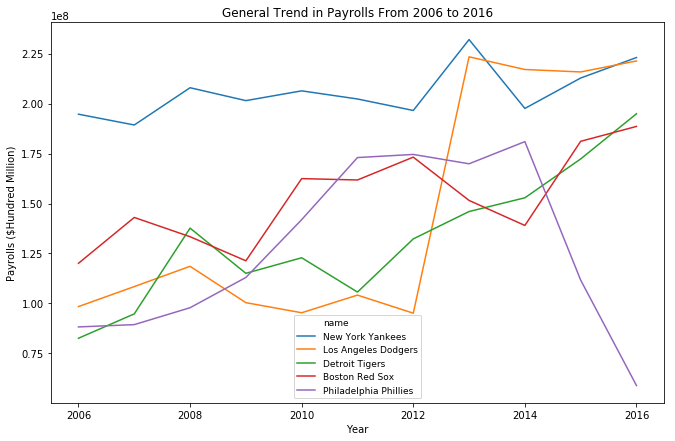

In [9]:
# General trend in payrolls over the ten years.
# Subset the payrolls of the top 5 teams from 2006 to 2016
# The DISTINCT keyword limits rows to distinct results.

top_5 = pd.read_sql("""

       SELECT teamid, payrolls, yearid, name FROM
       (
            SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
            (
            SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                (SELECT * FROM Salaries
                WHERE yearID >= 2006 AND yearID <= 2016) as S
                LEFT JOIN
                (SELECT teamid, name FROM Teams
                WHERE yearID >= 2006 AND yearID <= 2016) as T
                ON S.teamID = T.teamID
            )    
            GROUP BY teamid, yearID ORDER BY payrolls DESC     
        )
        WHERE name = "New York Yankees" OR name = "Los Angeles Dodgers" OR 
        name = "Detroit Tigers" OR name = "Boston Red Sox" OR name = "Philadelphia Phillies";
""", db)

# Line plot
plot1 = plt.figure(figsize=(11, 7))
sns.lineplot(x = "yearid", y = "payrolls", hue = "name", data = top_5)

# Add title and axis names
plt.title('General Trend in Payrolls From 2006 to 2016')
plt.xlabel('Year')
plt.ylabel('Payrolls ($Hundred Million)')
plt.legend(loc="lower center", prop={'size': 9})


### 1.3 Findings based on the graphs

Based on the graph in the previous problem, the two most obvious anomalies in the payrolls over the ten years are among Los Angeles Dodgers from 2012 to 2014 and Philadephia Phillies from 2014 to 2016. According to Wikipedia (https://en.wikipedia.org/wiki/2012_Los_Angeles_Dodgers_season), the agreement had been reached on the sale of the Dodgers in 2012 due to it's former owner Frank McCourt's bankrupcy and seperation with his wife. "The sale price of the Dodgers was considered to be far higher than what the team was actually worth at the time of sale." Therefore there was a sharp rise in the Dodgers' payrolls from 2012 to 2014. Another anomaly is the big dip in the Phillies' payrolls starting from 2014. One reason is that the Phillies have seen a precipitous drop in attendance over these time period, as the team has failed to perform on the field. (https://blogs.fangraphs.com/what-are-the-phillies-waiting-for/)

### 1.4 How do the top 5 teams compare to other teams?

In [10]:
# subset the payrolls of the top 5 teams and avergae payrolls of the other teams seperately
# The SELECT command selects rows from a table.
# Join the two tables
# The ORDER BY keyword sorts the returned rows by payrolls and yearid.
# WHERE puts conditions on the rows returned which subet the year from 2006 to 2016. 

other_teams = pd.read_sql("""
        SELECT payrolls, b.yearid, name, other_payrolls FROM
        
            (SELECT yearid, AVG(payrolls) AS other_payrolls FROM
            (
               SELECT teamid, payrolls, yearid, name FROM
               (
                    SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
                    (
                    SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                        (SELECT * FROM Salaries
                        WHERE yearID >= 2006 AND yearID <= 2016) as S
                        LEFT JOIN
                        (SELECT teamid, name FROM Teams
                        WHERE yearID >= 2006 AND yearID <= 2016) as T
                        ON S.teamID = T.teamID
                    )    
                    GROUP BY teamid, yearID ORDER BY payrolls DESC     
                )
                WHERE name != "New York Yankees" AND name != "Los Angeles Dodgers" AND 
                name != "Detroit Tigers" AND name != "Boston Red Sox" AND name != "Philadelphia Phillies"
            )
            GROUP BY yearid ORDER BY yearid) AS b
            LEFT JOIN
            (SELECT teamid, payrolls, yearid, name FROM
               (
                    SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
                    (
                    SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                        (SELECT * FROM Salaries
                        WHERE yearID >= 2006 AND yearID <= 2016) as S
                        LEFT JOIN
                        (SELECT teamid, name FROM Teams
                        WHERE yearID >= 2006 AND yearID <= 2016) as T
                        ON S.teamID = T.teamID
                    )    
                    GROUP BY teamid, yearID ORDER BY payrolls DESC     
                )
                WHERE name = "New York Yankees" OR name = "Los Angeles Dodgers" OR 
                name = "Detroit Tigers" OR name = "Boston Red Sox" OR name = "Philadelphia Phillies") AS c
            ON b.yearid = c.yearid
            ORDER BY payrolls DESC;
        """, db)

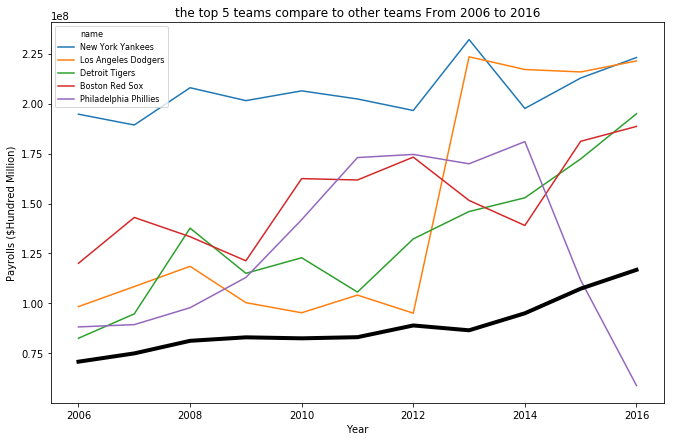

In [11]:
# LinePlot of the payrolls of the top 5 teams and avergae payrolls of the other teams.

plot2 = plt.figure(figsize=(11, 7))
sns.lineplot(x = "yearid", y = "payrolls", hue = "name", data = other_teams)

# The dark black line is the average payrolls of the other teams
p = sns.lineplot(x = "yearid", y = "other_payrolls", color='black',
             linewidth = 4, data = other_teams)

# Add title and axis names
plt.title('the top 5 teams compare to other teams From 2006 to 2016')
plt.xlabel('Year')
plt.ylabel('Payrolls ($Hundred Million)')
plt.legend(loc="upper left", prop={'size': 8})


To compare the top 5 teams with the other teams, I compute every year's average payroll of all the teams other than the top 5 teams. The dark black line in the line plot indicates the mean payroll of the other teams between 2006 and 2016. The graph shows that all each year's payrolls of the top 5 teams are above the other teams' except the payrolls of Philadelphia Phillies beyond 2015. 

### 2.1 Is there a relationship between the games winning rates and their payrolls?

In [12]:
# Get the winning rates in the team table
# by calulate games won/games played

percent = pd.read_sql('''
            SELECT a.teamid, a.name, win_rate, payrolls, w, a.yearid FROM
            
                (SELECT teamid, yearid, name, rank, g, w, l, ghome, CAST(w as FLOAT)/g win_rate FROM teams 
                WHERE yearid>=2001 AND yearid<=2016) AS a
                LEFT JOIN
                (SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
                (
                SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                (SELECT * FROM salaries
                WHERE yearid >= 2001 AND yearid <= 2016) as S
                LEFT JOIN
                (SELECT teamid, name FROM teams
                WHERE yearid >= 2001 AND yearid <= 2016) as T
                ON S.teamid = T.teamid
                )
                GROUP BY name, yearid) AS b
            
            ON a.teamid = b.teamid AND a.yearid = b.yearid
            ORDER BY payrolls DESC
''',db)

(0.3, 0.7)

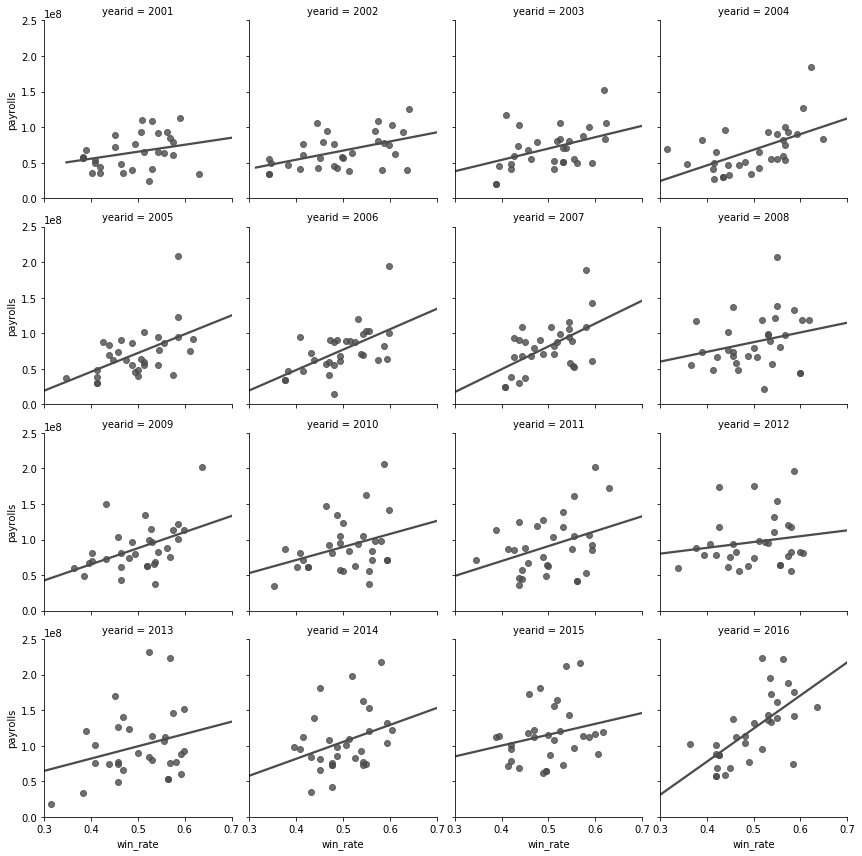

In [13]:
# Grid plot showing the payrolls vs. winning rates for years from 2001 through 2016 
p = sns.FacetGrid(col = "yearid", col_wrap = 4, data = percent)
p.map(sns.regplot, "win_rate", "payrolls", color=".3", ci=None)


# control x and y limits
plt.ylim(0, 250000000)
plt.xlim(0.3, 0.7)

My assumption for this question is that there is a positive relationship between the rates of winning and the total amount of annual salaries among all players in a team in a given year. My approach is to compute the percentages of winning for all teams within 2001 and 2016, which are number of wins divided by the total games played, then make a scatter plot for each year individually to compare their relationship since inflation should be considered. 

All the plots above shows a positive relationship between the rates of winning and payrolls; however, the correlations are not fairly high among years before 2016, and 2016 reflects the highest correlations of all. In other words, if the players are the better the players performed in games, they are more likely to receive higher salaries. As a result, I can conclude that one possible factor of getting high payrolls is getting high winning rates. 


### 2.2 How much have salaries increased from 2006 to 2016 in real dollars?

In [14]:
# CPI data is from:
# https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/

cpi = [201.6, 207.3, 215.030, 214.537, 218.056, 224.939, 229.594, 232.957, 236.736, 237.017, 240.007]

p = pd.read_sql('''
    SELECT yearid, AVG(payrolls) AS Nominal_Avg_Payrolls FROM
    (
        SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
            (
            SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                (SELECT * FROM Salaries
                WHERE yearID >= 2006 AND yearID <= 2016) as S
                LEFT JOIN
                (SELECT teamid, name FROM Teams
                WHERE yearID >= 2006 AND yearID <= 2016) as T
                ON S.teamID = T.teamID
            )    
            GROUP BY teamid, yearid ORDER BY payrolls DESC  
       ) 
        GROUP BY yearid;
''',db)

p["cpi"] = cpi
p["Real_Avg_Payrolls"] = p["Nominal_Avg_Payrolls"] / p["cpi"] * 100


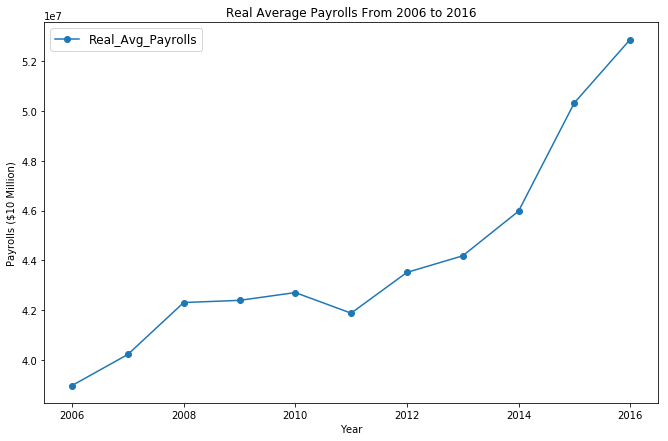

In [24]:

plt.figure(figsize=(11, 7))
#sns.lineplot(x = "yearid", y = "Real_Avg_Payrolls", data = p)
plt.plot( 'yearid', 'Real_Avg_Payrolls', data=p, linestyle='-', marker='o')

# Add title and axis names
plt.title('Real Average Payrolls From 2006 to 2016')
plt.xlabel('Year')
plt.ylabel('Payrolls ($10 Million)')
plt.legend(loc="upper left", prop={'size': 12})

My hypothesis for this question is that the salaries of baseball players are increasing because baseball is well established and widely played in the United States. Since the datasets contain only nominal salaries, I have to convert nominal payrolls to real payrolls which are inflation-adjusted. Inflation refers to the increase in the general price of goods and services, and The Consumer Price Index (CPI)  is the most widely used measure of inflation. CPI is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food and medical care. (Refer to: https://www.investopedia.com/terms/c/consumerpriceindex.asp) Therefore, I look up the average annual CPI for year 2006 through 2016 and compute average payrolls among all the teams in real dollars. 

Over the ten year period, real average payrolls of baseball teams are rising except for 2011 through 2011. Overall, baseball has a large following in the United States; a 2006 poll found that nearly half of Americans are fans. (https://en.wikipedia.org/wiki/Baseball#Rise_of_Ruth_and_racial_integration) Thus, it’s not surprised that the salaries of baseball players are increasing. 

### 2.3 : How the winning rates have changed for the top 5 teams with the most payrolls from 2006 to 2016?

In [592]:
# Join the tables of teams and salaries on teamid
 
wins = pd.read_sql('''
        SELECT * FROM
        (
            SELECT a.teamid, a.name, win_rate, payrolls, w, a.yearid FROM
                (SELECT teamid, yearid, name, rank, g, w, l, ghome, CAST(w as FLOAT)/g win_rate FROM teams 
                WHERE yearid>=2006 AND yearid<=2016) AS a
                LEFT JOIN
                (SELECT teamid, SUM(salary) AS payrolls, yearid, name FROM
                (
                SELECT DISTINCT playerid, yearid, s.teamid, salary, name FROM
                (SELECT * FROM salaries
                WHERE yearid >= 2006 AND yearid <= 2016) as S
                LEFT JOIN
                (SELECT teamid, name FROM teams
                WHERE yearid >= 2006 AND yearid <= 2016) as T
                ON S.teamid = T.teamid
                )
                GROUP BY name, yearid) AS b
              ON a.teamid = b.teamid AND a.yearid = b.yearid
              )
              WHERE name = "New York Yankees" OR name = "Los Angeles Dodgers" OR 
              name = "Detroit Tigers" OR name = "Boston Red Sox" OR name = "Philadelphia Phillies";
''',db)

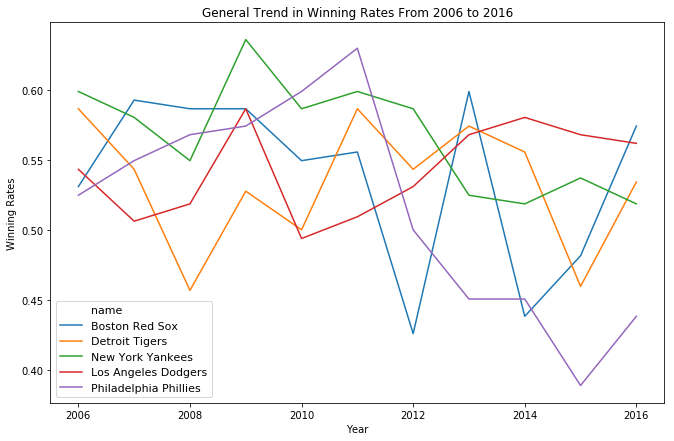

In [602]:
# Line plot - the changes of the winning rates for the top 5 teams with the most payrolls from 2006 to 2016
plot5 = plt.figure(figsize=(11, 7))
sns.lineplot(x = "yearid", y = "win_rate", hue = "name", data = wins)

# Add title and axis names
plt.title('General Trend in Winning Rates From 2006 to 2016')
plt.xlabel('Year')
plt.ylabel('Winning Rates')
plt.legend(loc="lower left", prop={'size': 11})

For this question, I am going to explore the winning rates of the top 5 teams that have the most payrolls within 2006 to 2016. 

Recall to question 1.1.1, the 5 teams that had the highest payrolls at any time over the 10 year period from 2006 to 2016 are New York Yankees, Los Angeles Dodgers, Detroit Tigers, Boston Red Sox, and Philadelphia Phillies. According to the graph, the winning rates of these teams fluctuated a lot from 2006 to 2016 especially for Philadelphia Phillies. Before 2011, Phillies is one of the top 3 most won team; however, Phillies experienced a huge decline starting from 2011 and until 2015. This result matches problem 1.1.3 that a big dip had happened in Phillies' payrolls over this time period. Now, I can see a relationship between Phillies’ payrolls and their winning rates; in other words, one major factor of the fall of Phillies’ salaries is their drop in winning rates. 